# GSoC Progress Demonstration Notebook
*This notebook demonstrates progress on the GSoC 2020 project entitled [PySAL ESDA Enhancements: Local join count and LOSH statistics](https://docs.google.com/document/d/1WjHjy5Eyk4WG5QWfnsnhWg1r4-e09JXXCx0iaPphg6c/edit).*

Towards the final week of GSoC Phase 1 (end date: July 3rd), the PySAL GSoC mentees were encouraged to collect the progress made on the projects. This notebook will demonstrate four new estimators:
- local spatial heteroskedasticity, LOSH (function name: `losh`, [validation notebook](https://github.com/jeffcsauer/GSOC2020/blob/master/validation/Validation_LOSH.ipynb))
- univariate local join counts (function name: `Local_Join_Count`, [validation notebook](https://github.com/jeffcsauer/GSOC2020/blob/master/validation/Validation_LJC_univariate.ipynb))
- bivariate local join counts (function name: `Local_Join_Count_BV`, [validation notebook](https://github.com/jeffcsauer/GSOC2020/blob/master/validation/Validation_LJC_bivariate.ipynb))
- multivariate local join counts (function name: `Local_Join_Count_MV`, [validation notebook](https://github.com/jeffcsauer/GSOC2020/blob/master/validation/Validation_LJC_multivariate.ipynb))

Here we will focus only on demonstrating each function and comparing it to an external output, such as the `R` `spdep` package or GeoDa. If you are interested in working through the functions in a step-by-step fashion, please refer to the above validation notebooks.

The following table summarizes the progress made so far and highlights what work still needs to be done.

| Function              | Generating correct values? | Generating correct inference? | PEP8 styling? | Docstrings | Tests      |
|-----------------------|----------------------------|-------------------------------|---------------|------------|------------|
| `LOSH`                | Yes                        | Yes                           | Mostly        | Mostly     | Need to do |
| `Local_Join_Count`    | Yes                        | Yes                           | Mostly        | Mostly     | Need to do |
| `Local_Join_Count_BV` | Selectively                | No for Case 1, Yes for Case 2 | Mostly        | Mostly     | Need to do |
| `Local_Join_Count_MV` | Yes                        | Yes                           | Mostly        | Mostly     | Need to do |

## Local spatial heteroskedasticity (LOSH)

We first grab the [`losh.py`](https://github.com/jeffcsauer/GSOC2020/blob/master/functions/losh.py) function.

In [1]:
import numpy as np
import warnings
from scipy import sparse
from scipy import stats
from sklearn.base import BaseEstimator
from libpysal import weights


class losh(BaseEstimator):
    """Local spatial heteroscedasticity (LOSH)"""

    def __init__(self, connectivity=None, inference=None):
        """
        Initialize a losh estimator

        Arguments
        ---------
        connectivity: scipy.sparse matrix object
                      the connectivity structure describing the relationships
                      between observed units.
        inference: str
                   describes type of inference to be used. options are
                   "chi-square", "permutation", or "simulation".

        Attributes
        ----------
        Hi: numpy array
            Array of LOSH values for each spatial unit.    
        ylag: numpy array
              Spatially lagged y values.
        yresid: numpy array
                Spatially lagged residual values.
        VarHi: numpy array
               Variance of Hi.
        pval: numpy array
              P-values for inference based on either "chi-square", 
              "permutation", or "simulation" approaches.
        """
        
        self.connectivity = connectivity
        self.inference = inference
        
    def fit(self, y, a=2):
        """
        Arguments
        ---------
        y       :   numpy.ndarray
                    array containing continuous data
        a       :   int
                    residual multiplier. Default is 2 in order to generate a
                    variance measure. Users may use 1 for absolute deviations.

        Returns
        -------
        the fitted estimator.

        Notes
        -----
        Technical details and derivations can be found in :cite:`OrdGetis2012`.
        """
        y = np.asarray(y).flatten()
        
        w = self.connectivity

        self.Hi, self.ylag, self.yresid, self.VarHi = self._statistic(y, w, a)
        
        if self.inference is None:
            return self
        elif self.inference == 'chi-square':
            if a != 2:
                warnings.warn(f'Chi-square inference assumes that a=2, but a={a}. This means the inference will be invalid!')
            else:
                dof = 2/self.VarHi
                Zi = (2*self.Hi)/self.VarHi
                self.pval = 1 - stats.chi2.cdf(Zi, dof)
        else:
            raise NotImplementedError(f'The requested inference method ({self.inference}) is not currently supported!')
        
        return self

    @staticmethod
    def _statistic(y, w, a):
        # Define what type of variance to use
        if a is None:
            a = 2
        else:
            a = a
         
        rowsum = np.array(w.sparse.sum(axis=1)).flatten()
        
        # Calculate spatial mean
        ylag = weights.lag_spatial(w, y)/rowsum
        # Calculate and adjust residuals based on multiplier
        yresid = abs(y-ylag)**a
        # Calculate denominator of Hi calculation 
        # as mean of residuals - does np.mean need to be an int?
        denom =  np.mean(yresid) * np.array(rowsum)
        # Carry out final $H_{i}$ calculation by dividing
        # spatial average of residuals by denom
        Hi = weights.lag_spatial(w, yresid) / denom
        
        # Calculate variance
        n = len(y)
        # Calculate average of residuals
        yresid_mean = np.mean(yresid)
        # Calculate VarHi
        squared_rowsum = np.asarray(w.sparse
                           .multiply(w.sparse)
                           .sum(axis=1)
                          ).flatten()
                          
        VarHi =  ((n-1)**-1) * \
                 (denom**-2) * \
                 ((np.sum(yresid**2)/n) - yresid_mean**2) * \
                 ((n*squared_rowsum) - (rowsum**2))

        return (Hi, ylag, yresid, VarHi)

There are a couple of things to note about the above `losh` function. Inference is currently based on the $\chi^2$ distribution. [Alternative methods have been suggested](https://link.springer.com/article/10.1007/s00168-014-0605-5), and we may implement these in the future. Although the user may get absolute deviations via `a=1`, we warn users that $\chi^2$ inference requires `a=2`.

We are going to run the `losh` function on the [Denver Housing Dataset](https://geodacenter.github.io/data-and-lab//census_2010_excluded-variables/), specifically the `HU_RENTED` variable (i.e. 'Number of renter-occupied housing units'). We will then compare our output to results from `R`'s `spdep::LOSH()`. If you are interested in seeing how the validation was created in R, you may reference [`Validation_LOSH_real_world.Rmd`](https://github.com/jeffcsauer/GSOC2020/blob/master/validation/data/Validation_LOSH_real_world.Rmd), the results of which are stored in the [`spdep_denver_losh.csv`](https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/spdep_denver_losh.csv')
.

In [2]:
import geopandas as gpd
denver = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/denver/denver.gpkg')

# Create weights
# Note that the function does not automatically row-standardizes the data, 
# but the actual calculations render the same values.

# Standardized
wq_denver_rs = weights.Queen.from_dataframe(denver)
wq_denver_rs.transform = 'r'

# Nonstandardized
wq_denver_ns = weights.Queen.from_dataframe(denver)

Run the `losh` function twice to get both nonstandardized and standardized results.

In [3]:
losh_rs = losh(connectivity=wq_denver_rs, inference="chi-square").fit(denver['HU_RENTED'])
losh_ns = losh(connectivity=wq_denver_ns, inference="chi-square").fit(denver['HU_RENTED'])

We can now compare our results to the `R` `spdep::LOSH()` results. We focus on $H_i$ (LOSH values), $VarH_i$ (variance of the LOSH values), and the $\chi^2$ p-values as these are of most interest to the users.

In [4]:
import pandas as pd
Hi_spdep = pd.read_csv('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/spdep_denver_losh.csv')

Comparison of results when passing nonstandardized weights through the function:  

$H_i$: the LOSH value

In [5]:
np.round(losh_rs.Hi, 3) == np.round(Hi_spdep['Hi'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

$VarH_i$: variance of the LOSH value

In [6]:
np.round(losh_rs.VarHi, 3) == np.round(Hi_spdep['Var.Hi'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

$ pvalues $

In [7]:
np.round(losh_rs.pval, 3) == np.round(Hi_spdep['Pr()'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Comparison of results when passing standardized weights through the function:  

$H_i$: the LOSH value

In [8]:
np.round(losh_ns.Hi, 3) == np.round(Hi_spdep['Hi'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

$VarH_i$: variance of the LOSH value

In [9]:
np.round(losh_ns.VarHi, 3) == np.round(Hi_spdep['Var.Hi'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

$ pvalues $

In [10]:
np.round(losh_ns.pval, 3) == np.round(Hi_spdep['Pr()'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

We see that the results from the `losh()` function reasonably agree (at least three decimal places) to the `R` `spdep::LOSH()` function when passing both unstandardized and row-standardized weights.  

## Univariate local join counts

We now move on to the univariate local join counts. As before, we copy the `Local_Join_Count.py` function.

In [11]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from libpysal import weights

PERMUTATIONS = 999

class Local_Join_Count(BaseEstimator):

    """Univariate Local Join Count Statistic"""

    def __init__(self, connectivity=None, permutations=PERMUTATIONS):
        """
        Initialize a Local_Join_Count estimator
        Arguments
        ---------
        connectivity:   scipy.sparse matrix object
                        the connectivity structure describing the relationships
                        between observed units. Need not be row-standardized.
        Attributes
        ----------
        LJC       :   numpy array
                      array containing the univariate Local Join Counts (LJC).
        p_sim       :   numpy array
                        array containing the simulated p-values for each unit.
        
        """

        self.connectivity = connectivity
        self.permutations = permutations

    def fit(self, y, permutations=999):
        """
        Arguments
        ---------
        y       :   numpy.ndarray
                    array containing binary (0/1) data
        Returns
        -------
        the fitted estimator.
        Notes
        -----
        Technical details and derivations found in :cite:`AnselinLi2019`.
        """
        y = np.asarray(y).flatten()
        
        w = self.connectivity
        # Fill the diagonal with 0s
        w = weights.util.fill_diagonal(w, val=0)
        w.transform = 'b'
        
        self.y = y
        self.n = len(y)
        self.w = w
        
        self.LJC = self._statistic(y, w)
        
        if permutations:
            self._crand()
            sim = np.transpose(self.rjoins)
            above = sim >= self.LJC
            larger = above.sum(0)
            low_extreme = (self.permutations - larger) < larger
            larger[low_extreme] = self.permutations - larger[low_extreme]
            self.p_sim = (larger + 1.0) / (permutations + 1.0)
            # Set p-values for those with LJC of 0 to NaN
            self.p_sim[self.LJC==0] = 'NaN'
        
        return self

    @staticmethod
    def _statistic(y, w):
        # Create adjacency list. Note that remove_symmetric=False - this is
        # different from the esda.Join_Counts() function.
        adj_list = w.to_adjlist(remove_symmetric=False)
        zseries = pd.Series(y, index=w.id_order)
        focal = zseries.loc[adj_list.focal].values
        neighbor = zseries.loc[adj_list.neighbor].values
        LJC = (focal == 1) & (neighbor == 1)
        adj_list_LJC = pd.DataFrame(adj_list.focal.values,
                                   LJC.astype('uint8')).reset_index()
        adj_list_LJC.columns = ['LJC', 'ID']
        adj_list_LJC = adj_list_LJC.groupby(by='ID').sum()
        LJC = adj_list_LJC.LJC.values
        return (LJC)
    
    def _crand(self):
        """
        conditional randomization

        for observation i with ni neighbors,  the candidate set cannot include
        i (we don't want i being a neighbor of i). we have to sample without
        replacement from a set of ids that doesn't include i. numpy doesn't
        directly support sampling wo replacement and it is expensive to
        implement this. instead we omit i from the original ids,  permute the
        ids and take the first ni elements of the permuted ids as the
        neighbors to i in each randomization.

        """
        y = self.y
        n = len(y)
        joins = np.zeros((self.n, self.permutations))
        n_1 = self.n - 1
        prange = list(range(self.permutations))
        k = self.w.max_neighbors + 1
        nn = self.n - 1
        rids = np.array([np.random.permutation(nn)[0:k] for i in prange])
        ids = np.arange(self.w.n)
        ido = self.w.id_order
        w = [self.w.weights[ido[i]] for i in ids]
        wc = [self.w.cardinalities[ido[i]] for i in ids]

        for i in range(self.w.n):
            idsi = ids[ids != i]
            np.random.shuffle(idsi)
            tmp = y[idsi[rids[:, 0:wc[i]]]]
            joins[i] = y[i] * (w[i] * tmp).sum(1)
        self.rjoins = joins

Unlike the `losh` function, all of the join count functions currently use conditional randomization for inference. Perhaps the most interesting thing to note about the above function is the creation of the adjacency list (`adj_list = w.to_adjlist(remove_symmetric=False)`. Unlike the `esda.Join_Counts()` function, we use `remove_symmetric=False` in order to capture the number of local join counts for each unit, rather than the global total.

Ideally, we would look to compare our function's output to the values from the [Anselin and Li 2019 paper](https://link.springer.com/article/10.1007%2Fs10109-019-00299-x). However, the replication data is not yet publicly available. Thus, we compare our results to the output from GeoDa using a common example dataset. Specifically, we use the [Baltimore Housing Sales dataset](https://geodacenter.github.io/data-and-lab/baltim/) and focus on the `dwell` binary variable. We use a k-nearest neighbor (n=5) weighting scheme.

In [12]:
balt = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/baltimore_housing.gpkg')
points = list(zip(balt['x'], balt['y']))
import libpysal
kd = libpysal.cg.KDTree(np.array(points))
balt_knn5 = libpysal.weights.KNN(kd, k=5) 

We now run the `Local_Join_Count` function on the `dwell` variable.

In [13]:
test_results = Local_Join_Count(connectivity=balt_knn5).fit(balt['dwell'])

Now let's compare our results to those of GeoDa. Instructions on how to replicate these results are available [here](https://github.com/jeffcsauer/GSOC2020/blob/master/validation/data/baltimore/GeoDa%20replication%20instructions.txt).

In [14]:
GeoDa_LJC = pd.read_csv('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/balt_knn_5_LJC_univariate.csv')
results = test_results.LJC == GeoDa_LJC['JC']
results.value_counts()

True    211
Name: JC, dtype: int64

It seems all of the local join count values match with those of GeoDa. Due to the conditional randomization, the p-values cannot be compared for exact equivalency. However, we can still assess the p-values through methods like correlation and scatter plots to assess agreement.

The correlation between the PySAL and GeoDa p-values is 0.9940469732715038


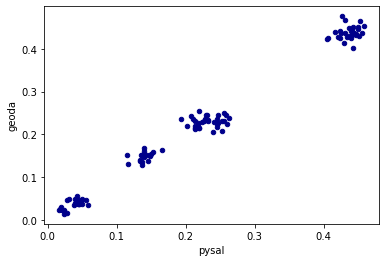

In [15]:
# Assess correlation between p-values
corrdf = pd.DataFrame(test_results.p_sim, GeoDa_LJC.PP_VAL).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the PySAL and GeoDa p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

We see a very high correlation between the PySAL and GeoDa p-values (0.993), as well as clearly clustered p-values in the scatterplot (i.e. no extreme outliers or strange patterns). 

## Bivariate local join counts

We repeat a similar process for bivariate local join counts. Before jumping in, it is important to contextualize the two cases with which this function is used: 

**Case 1: No co-location of phenomenon of interest**

From Anselin and Li, 2019:
> The first case considers the situation where $x_i$ and $z_i$ do not take on the same value at $i$ or $j$. In other words, when $x_i = 1$ for location $i$, then $z_i = 0$. We count the number of neighbors of $i$ with $x_i = 1$ for which the value of $z_j = 1$ (and also $x_j = 0$).

**Case 2: Co-location cluster (CLC) of phenomenon of interest**

From Anselin and Li, 2019: 
> A second perspective on the bivariate case is when the interest is in co-located events being surrounded by other co-located events. We refer to this case as a colocation cluster (CLC). This requires both $x_i = z_i = 1$ as well as $x_j = z_j = 1$ for the
neighbors.

**Accessing the functions in GeoDa**

> In GeoDa, the co-location case [Case 2] is treated under Multivariate Local Join Count (which includes the bivariate setup as a special case), whereas the no co-location case [Case 1] is implemented under Bivariate Local Join Count.

**Additional notes**

It should be noted that I am observing some odd behavior with this function. Namely, my function generates the correct values on a toy dataset, and can selectively match certain results from GeoDa (see the validation notebook linked at the beginning). However, there is also some disagreement between my function and GeoDa. I am currenlty working on resolving these disagreements and you can see a more detailed breakdown of this disagreement [here](https://github.com/jeffcsauer/GSOC2020/blob/master/validation/Understanding_BV_LJC.ipynb). Inference is available for Case 2, but an additional meeting is needed for inference on Case 1.

Below is `Local_Join_Counts_BV.py`.

In [16]:
import numpy as np
import pandas as pd
import warnings
from scipy import sparse
from sklearn.base import BaseEstimator
from libpysal import weights

PERMUTATIONS = 999

class Local_Join_Count_BV(BaseEstimator):

    """Bivariate local join counts"""

    def __init__(self, connectivity=None, permutations=PERMUTATIONS):
        """
        Initialize a Local_Join_Count_BV estimator
        Arguments
        ---------
        connectivity:   scipy.sparse matrix object
                        the connectivity structure describing the relationships
                        between observed units. Will be row-standardized.
        Attributes
        ----------
        LJC       :   numpy.ndarray
                      array containing the estimated Bivariate Local Join Counts
        p_sim       :   numpy.ndarray
                        array containing the simulated p-values for each unit.
        """

        self.connectivity = connectivity
        self.permutations = permutations

    def fit(self, x, z, case="CLC", permutations=999):
        """
        Arguments
        ---------
        x       :   numpy.ndarray
                    array containing binary (0/1) data
        y       :   numpy.ndarray
                    array containing binary (0/1) data
        Returns
        -------
        the fitted estimator.
        Notes
        -----
        Technical details and derivations can be found in :cite:`AnselinLi2019`.
        """
        x = np.asarray(x).flatten()
        z = np.asarray(z).flatten()

        w = self.connectivity
        # Fill the diagonal with 0s
        w = weights.util.fill_diagonal(w, val=0)
        w.transform = 'b'

        self.x = x
        self.z = z
        self.n = len(x)
        self.w = w
        self.case = case

        self.LJC = self._statistic(x, z, w, case=case)

        if permutations:
            self._crand()
            sim = np.transpose(self.rjoins)
            above = sim >= self.LJC
            larger = above.sum(0)
            low_extreme = (self.permutations - larger) < larger
            larger[low_extreme] = self.permutations - larger[low_extreme]
            self.p_sim = (larger + 1.0) / (permutations + 1.0)
            # Set p-values for those with LJC of 0 to NaN
            self.p_sim[self.LJC==0] = 'NaN'

        return self

    @staticmethod
    def _statistic(x, z, w, case):
        # Create adjacency list. Note that remove_symmetric=False - this is
        # different from the esda.Join_Counts() function.
        adj_list = w.to_adjlist(remove_symmetric=False)

        # First, set up a series that maps the values
        # to the weights table
        zseries_x = pd.Series(x, index=w.id_order)
        zseries_z = pd.Series(z, index=w.id_order)

        # Map the values to the focal (i) values
        focal_x = zseries_x.loc[adj_list.focal].values
        focal_z = zseries_z.loc[adj_list.focal].values

        # Map the values to the neighbor (j) values
        neighbor_x = zseries_x.loc[adj_list.neighbor].values
        neighbor_z = zseries_z.loc[adj_list.neighbor].values

        if case == "BJC":
            BJC = (focal_x == 1) & (focal_z == 0) & \
                  (neighbor_x == 0) & (neighbor_z == 1)
            adj_list_BJC = pd.DataFrame(adj_list.focal.values,
                                        BJC.astype('uint8')).reset_index()
            adj_list_BJC.columns = ['BJC', 'ID']
            adj_list_BJC = adj_list_BJC.groupby(by='ID').sum()
            return (adj_list_BJC.BJC.values)
        elif case == "CLC":
            CLC = (focal_x == 1) & (focal_z == 1) & \
                  (neighbor_x == 1) & (neighbor_z == 1)
            adj_list_CLC = pd.DataFrame(adj_list.focal.values,
                                        CLC.astype('uint8')).reset_index()
            adj_list_CLC.columns = ['CLC', 'ID']
            adj_list_CLC = adj_list_CLC.groupby(by='ID').sum()
            return (adj_list_CLC.CLC.values)
        else:
            raise NotImplementedError(f'The requested LJC method ({case}) is not currently supported!')
            
    def _crand(self):
        """
        conditional randomization

        for observation i with ni neighbors,  the candidate set cannot include
        i (we don't want i being a neighbor of i). we have to sample without
        replacement from a set of ids that doesn't include i. numpy doesn't
        directly support sampling wo replacement and it is expensive to
        implement this. instead we omit i from the original ids,  permute the
        ids and take the first ni elements of the permuted ids as the
        neighbors to i in each randomization.

        """
        x = self.x
        z = self.z
        xz = ((x==1) & (z==0)).astype('uint8')
        case = self.case
        
        n = len(x)
        joins = np.zeros((self.n, self.permutations))
        n_1 = self.n - 1
        prange = list(range(self.permutations))
        k = self.w.max_neighbors + 1
        nn = self.n - 1
        rids = np.array([np.random.permutation(nn)[0:k] for i in prange])
        ids = np.arange(self.w.n)
        ido = self.w.id_order
        w = [self.w.weights[ido[i]] for i in ids]
        wc = [self.w.cardinalities[ido[i]] for i in ids]

        for i in range(self.w.n):
            idsi = ids[ids != i]
            np.random.shuffle(idsi)
            tmp_x = x[idsi[rids[:, 0:wc[i]]]]
            tmp_z = z[idsi[rids[:, 0:wc[i]]]]
            tmp_xz = xz[idsi[rids[:, 0:wc[i]]]]
            if case == "BJC":
                joins[i] = z[i] * (w[i] * tmp_xz).sum(1)
            elif case == "CLC":
                joins[i] = z[i] * (w[i] * tmp_z * tmp_x).sum(1)
            else:
                raise NotImplementedError(f'The requested LJC method ({case}) is not currently supported!')
        self.rjoins = joins

Again, we compare the results from the `Local_Join_Counts_BV` to the output from GeoDa using the [Baltimore Housing Sales dataset](https://geodacenter.github.io/data-and-lab/baltim/). We consider `dwell` as the $x$ variable and `patio` as the $z$ variable. We must be careful about the order in which the variables are entered into the function - changing the order will alter both the calculation and context of the research question. We use the same knn (n=5) neighbor structure.

In [19]:
# Test results Case 1
test_results_case1 = Local_Join_Count_BV(connectivity=balt_knn5).fit(balt['dwell'], balt['patio'], case="BJC")
# Test results Case 2
test_results_case2 = Local_Join_Count_BV(connectivity=balt_knn5).fit(balt['dwell'], balt['patio'], case="CLC")

Load in the GeoDa results.

In [21]:
GeoDa_LJC = pd.read_csv('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/balt_knn_5_LJC_bivariate.csv')

As previously mentioned, this is where some disagreement between the functions emerge. Let's tabulate the agreement of the local join counts between `Local_Join_Count_BV` and GeoDa.

In [22]:
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):")
results = test_results_case1.LJC == GeoDa_LJC['JC_C1']
print(results.value_counts())
print("--------------------------")
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 2):")
results = test_results_case2.LJC == GeoDa_LJC['JC_C2']
print(results.value_counts())

Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):
True     179
False     32
Name: JC_C1, dtype: int64
--------------------------
Comparison of GeoDa bivariate LJC to PySAL implementation (Case 2):
True    211
Name: JC_C2, dtype: int64


Quite interestly, we get 100% matching on Case 2, but only ~85% matching on Case 1. When we apply the function on other datasets (such as the `commpop` dataset), the agreement can be reserved such that our function correctly produces the results for Case 1 but not Case 2 (see the detailed breakdown [here](https://github.com/jeffcsauer/GSOC2020/blob/master/validation/Understanding_BV_LJC.ipynb)). Regardless, we examine the agreement of the p-values as before:

The correlation between the two sets of p-values is 0.9978680199104879


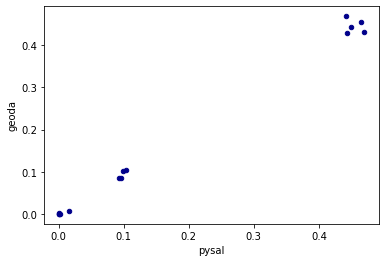

In [23]:
# Assess correlation between p-values
corrdf = pd.DataFrame(test_results_case2.p_sim, GeoDa_LJC.PP_VAL_C2).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

We again see a very high correlation between the PySAL and GeoDa p-values (0.997), as well as clearly clustered p-values in the scatterplot (i.e. no extreme outliers or strange patterns). Once inference is sorted for Case 1 a similar assessment will be carried out.

## Multivariate local join counts

Lastly we consider the multivariate local join counts. This is an extension of the bivariate local join count statistic (case 2) for co-location clusters. Formally:

$$ CLC_i = \Pi^m_{h=1} x_{hi} \sum_j w_{ij} \Pi^m_{h=1} x_{hj} $$

Unlike the `Local_Join_Counts_BV`, we have not yet had any major problems with the multivariate extension. We copy the `Local_Join_Counts_MV.py` below: 

In [25]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.base import BaseEstimator
from libpysal import weights

PERMUTATIONS = 999

class Local_Join_Count_MV(BaseEstimator):

    """Multivariate local join counts"""

    def __init__(self, connectivity=None, permutations=PERMUTATIONS):
        """
        Initialize a Local_Join_Count_MV estimator
        Arguments
        ---------
        connectivity:   scipy.sparse matrix object
                        the connectivity structure describing the relationships
                        between observed units. Will be row-standardized.
        Attributes
        ----------
        LJC       :   numpy.ndarray
                      array containing the estimated Multivariate Local Join Counts.
        p_sim       :   numpy.ndarray
                        array containing the simulated p-values for each unit.
        """

        self.connectivity = connectivity
        self.permutations = permutations

    def fit(self, variables, permutations=999):
        """
        Arguments
        ---------
        variables     :   numpy.ndarray
                          array(s) containing binary (0/1) data
        Returns
        -------
        the fitted estimator.
        Notes
        -----
        Technical details and derivations can be found in :cite:`AnselinLi2019`.
        """

        w = self.connectivity
        # Fill the diagonal with 0s
        w = weights.util.fill_diagonal(w, val=0)
        w.transform = 'b'
        
        self.n = len(variables[0])
        self.w = w
        
        self.variables = variables
        
        self.ext = np.prod(np.vstack(variables), axis=0)

        self.LJC = self._statistic(variables, w)
        
        if permutations:
            self._crand()
            sim = np.transpose(self.rjoins)
            above = sim >= self.LJC
            larger = above.sum(0)
            low_extreme = (self.permutations - larger) < larger
            larger[low_extreme] = self.permutations - larger[low_extreme]
            self.p_sim = (larger + 1.0) / (permutations + 1.0)
            # Set p-values for those with LJC of 0 to NaN
            self.p_sim[self.LJC==0] = 'NaN'

        return self

    @staticmethod
    def _statistic(variables, w):
        # Create adjacency list. Note that remove_symmetric=False -
        # different from the esda.Join_Counts() function.
        adj_list = w.to_adjlist(remove_symmetric=False)

        # The zseries
        zseries = [pd.Series(i, index=w.id_order) for i in variables]
        # The focal values
        focal = [zseries[i].loc[adj_list.focal].values for
                 i in range(len(variables))]
        # The neighbor values
        neighbor = [zseries[i].loc[adj_list.neighbor].values for
                    i in range(len(variables))]

        # Find instances where all surrounding 
        # focal and neighbor values == 1
        focal_all = np.array(np.all(np.dstack(focal)==1, 
                                    axis=2))
        neighbor_all = np.array(np.all(np.dstack(neighbor)==1, 
                                       axis=2))
        MCLC = (focal_all == True) & (neighbor_all == True)
        # Convert list of True/False to boolean array 
        # and unlist (necessary for building pd.DF)
        MCLC = list(MCLC*1)
        
        # Create a df that uses the adjacency list
        # focal values and the BBs counts
        adj_list_MCLC = pd.DataFrame(adj_list.focal.values,
                                     MCLC).reset_index()
        # Temporarily rename the columns
        adj_list_MCLC.columns = ['MCLC', 'ID']
        adj_list_MCLC = adj_list_MCLC.groupby(by='ID').sum()

        return (adj_list_MCLC.MCLC.values)
            
    def _crand(self):
        """
        conditional randomization

        for observation i with ni neighbors,  the candidate set cannot include
        i (we don't want i being a neighbor of i). we have to sample without
        replacement from a set of ids that doesn't include i. numpy doesn't
        directly support sampling wo replacement and it is expensive to
        implement this. instead we omit i from the original ids,  permute the
        ids and take the first ni elements of the permuted ids as the
        neighbors to i in each randomization.

        """
        # converted y to z
        # renamed lisas to joins
        ext = self.ext
        # Get length based on first variable
        n = len(ext)
        joins = np.zeros((self.n, self.permutations))
        n_1 = self.n - 1
        prange = list(range(self.permutations))
        k = self.w.max_neighbors + 1
        nn = self.n - 1
        rids = np.array([np.random.permutation(nn)[0:k] for i in prange])
        ids = np.arange(self.w.n)
        ido = self.w.id_order
        w = [self.w.weights[ido[i]] for i in ids]
        wc = [self.w.cardinalities[ido[i]] for i in ids]

        for i in range(self.w.n):
            idsi = ids[ids != i]
            np.random.shuffle(idsi)
            tmp = ext[idsi[rids[:, 0:wc[i]]]]
            joins[i] = ext[i] * (w[i] * tmp).sum(1)
        self.rjoins = joins

Again, we compare the results from the `Local_Join_Counts_MV` to the output from GeoDa using the [Baltimore Housing Sales dataset](https://geodacenter.github.io/data-and-lab/baltim/). We consider `dwell` as the $x$ variable, `patio` as the $z$ variable, and `firepl` as the $y$ variable. We use the same knn (n=5) neighbor structure.

In [32]:
test_results = Local_Join_Count_MV(connectivity=balt_knn5).fit([balt['dwell'], balt['patio'], balt['firepl']])

Read in the results from the GeoDa analysis.

In [34]:
GeoDa_LJC = pd.read_csv('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/balt_knn_5_LJC_multivariate.csv')

Comparison of GeoDa multivariate LJC to PySAL implementation:
True    211
Name: MV_JC, dtype: int64


Compare the results.

In [35]:
print("Comparison of GeoDa multivariate LJC to PySAL implementation:")
results = test_results.LJC == GeoDa_LJC['MV_JC']
print(results.value_counts())

Comparison of GeoDa multivariate LJC to PySAL implementation:
True    211
Name: MV_JC, dtype: int64


Assess the p-values.

The correlation between the two sets of p-values is 0.9997794705653699


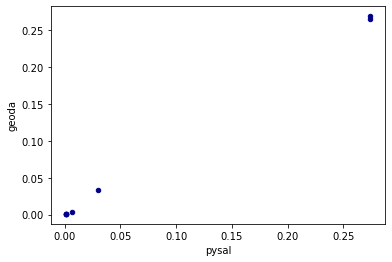

In [36]:
# Assess correlation between p-values
corrdf = pd.DataFrame(test_results.p_sim, GeoDa_LJC.MV_PP_VAL).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

We again see a very high correlation between the PySAL and GeoDa p-values (0.999), as well as clearly clustered p-values in the scatterplot (i.e. no extreme outliers or strange patterns).